APPLE STOCK PRICE PREDICTION SYSTEM
Coursework 2 - CU6051NP
LOADING DATA
✓ Loaded AppleStock.csv
  Shape: (2727, 7)

Columns and Data Types:
  - Date            | Type: object     | Null: 0
  - Open            | Type: object     | Null: 0
  - High            | Type: float64    | Null: 1
  - Low             | Type: float64    | Null: 1
  - Close           | Type: float64    | Null: 1
  - Adj Close       | Type: float64    | Null: 1
  - Volume          | Type: object     | Null: 1

First 3 rows:
        Date   Open   High    Low  Close   Adj Close        Volume
0  23-Jan-15  28.08  28.44  27.88   28.25       25.05  185,859,200
1  26-Jan-15  28.43  28.59  28.20   28.27       25.07  222,460,000
2  27-Jan-15   28.1  28.12  27.26   27.28       24.20  382,274,800

PREPARING FEATURES

1. Cleaning numeric columns...
  ✓ Cleaned column: Date
  ✓ Cleaned column: Open
  ✓ Cleaned column: Volume

2. Checking for missing values...
  Total NaN values: 2733

  NaN values by column:
    - Date: 2727 Na

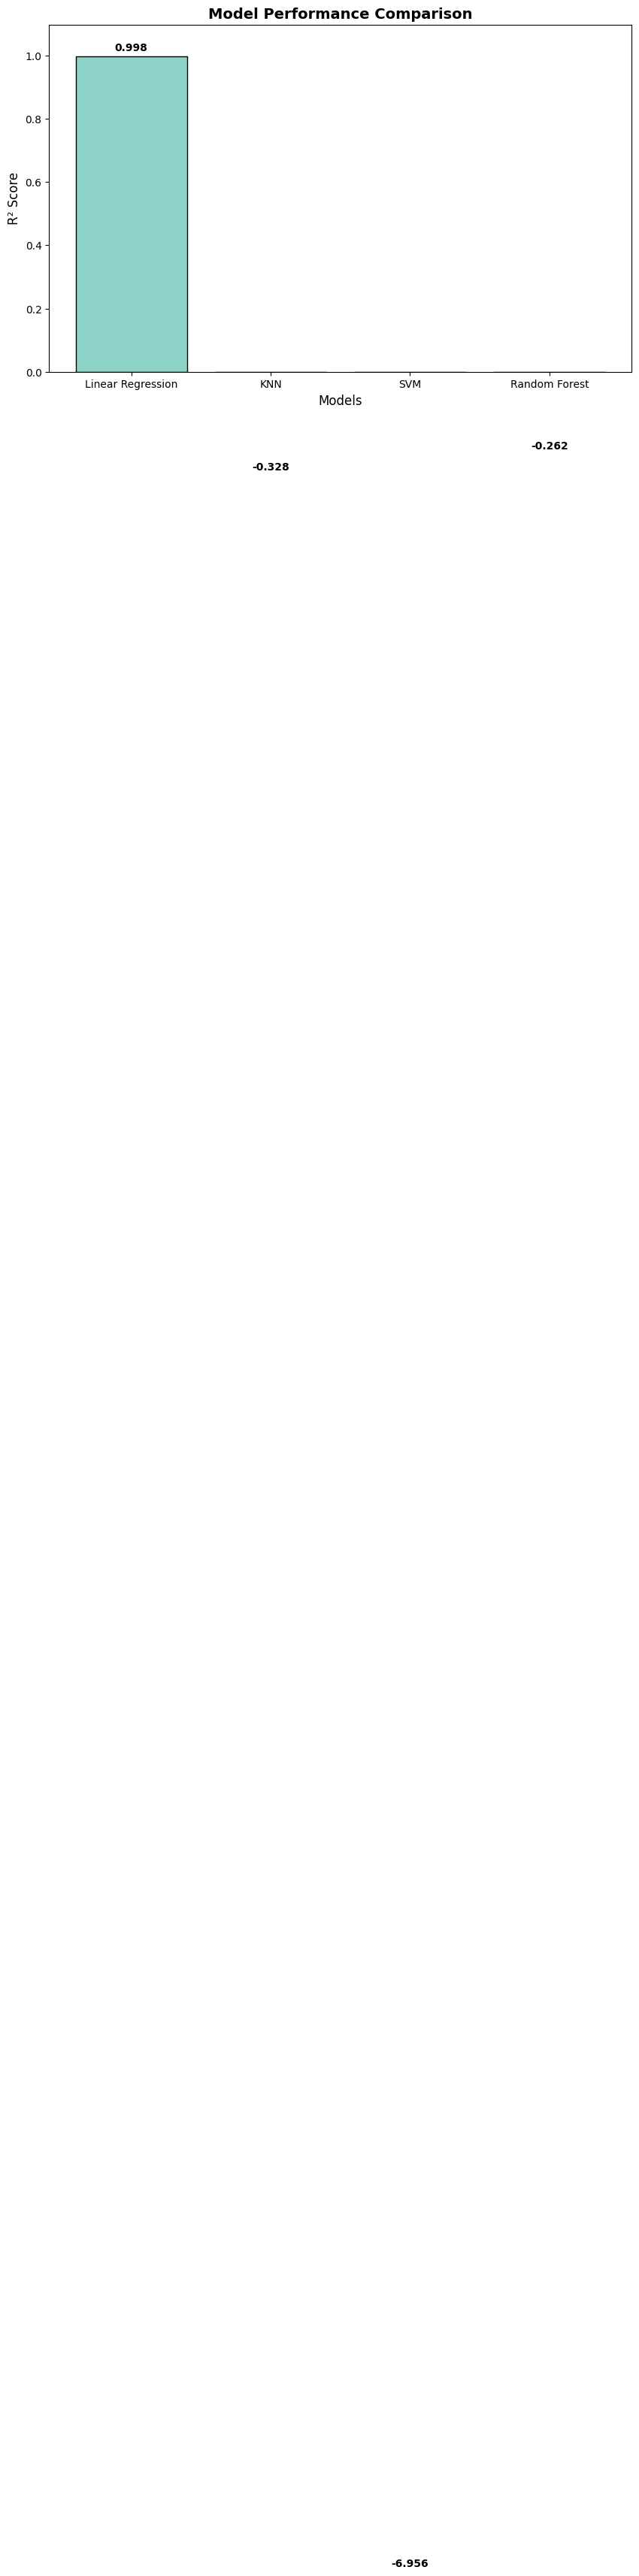

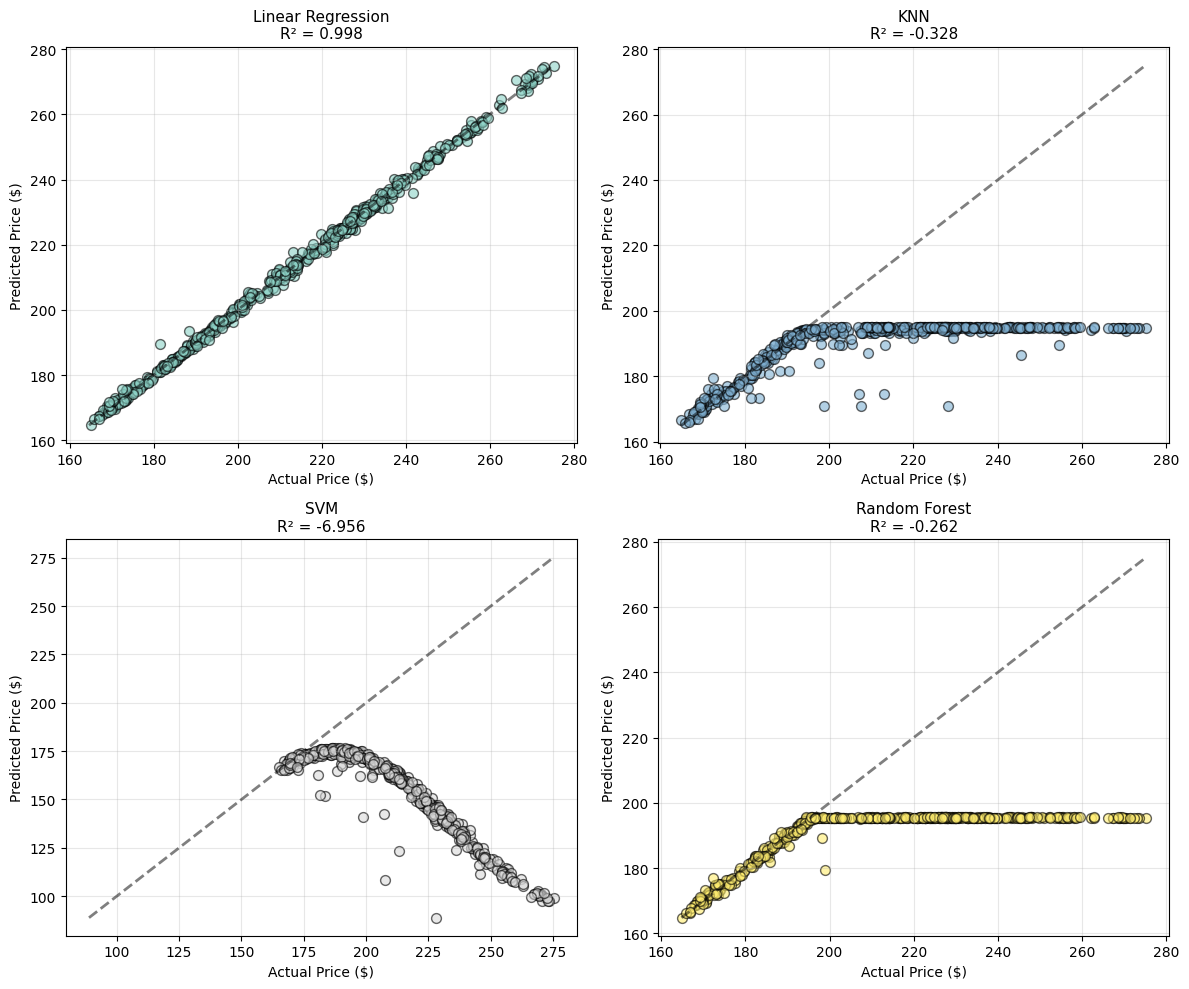

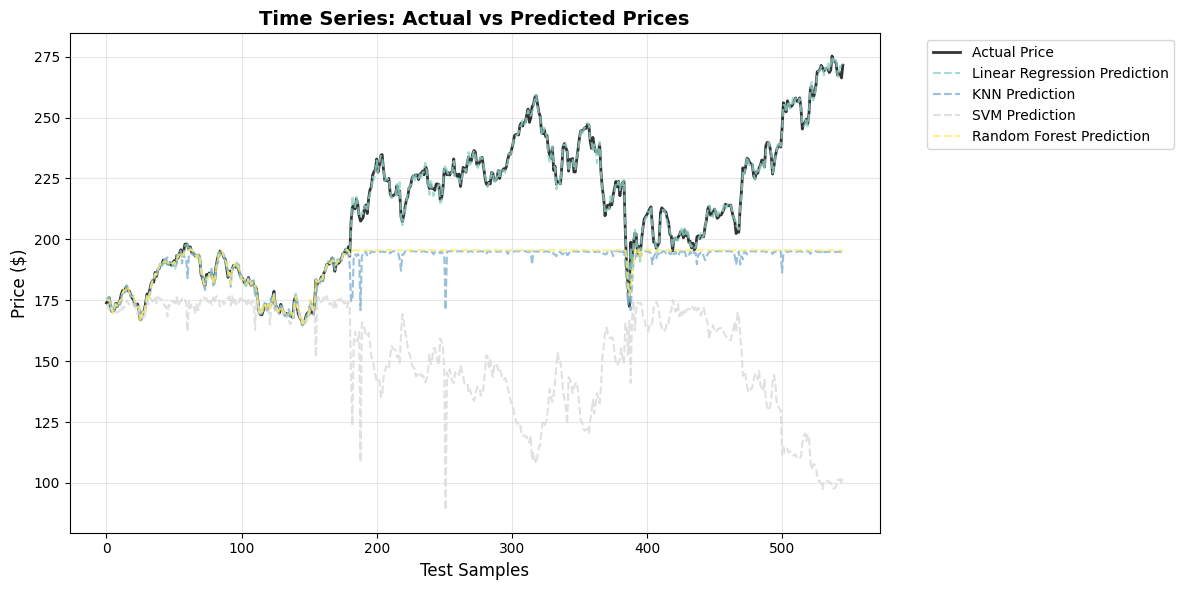

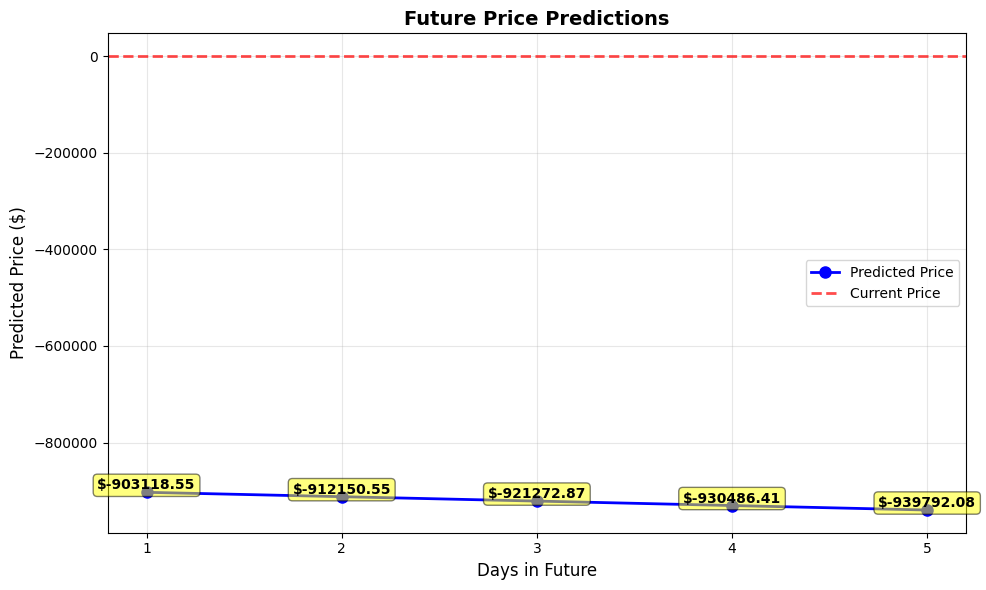

In [2]:
"""
APPLE STOCK PRICE PREDICTION SYSTEM
Coursework 2 - Artificial Intelligence (CU6051NP)
Fixed Version with NaN Handling
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Utilities
import os

# ============================================
# CONFIGURATION
# ============================================
class Config:
    """Configuration settings"""
    DATA_FILE = 'AppleStock.csv'
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

# ============================================
# DATA PROCESSOR
# ============================================
class DataProcessor:
    """Handles data loading and preprocessing with NaN handling"""
    
    def __init__(self, config):
        self.config = config
        self.df = None
        self.X = None
        self.y = None
        
    def load_and_clean_data(self):
        """Load and clean the data"""
        print("="*60)
        print("LOADING DATA")
        print("="*60)
        
        # Load data
        try:
            self.df = pd.read_csv(self.config.DATA_FILE)
            print(f"✓ Loaded {self.config.DATA_FILE}")
            print(f"  Shape: {self.df.shape}")
        except FileNotFoundError:
            print(f"✗ File '{self.config.DATA_FILE}' not found!")
            exit()
        
        # Show columns and data types
        print("\nColumns and Data Types:")
        for col in self.df.columns:
            dtype = str(self.df[col].dtype)
            null_count = self.df[col].isnull().sum()
            print(f"  - {col:15} | Type: {dtype:10} | Null: {null_count}")
        
        print(f"\nFirst 3 rows:")
        print(self.df.head(3))
        
        return self.df
    
    def prepare_features(self):
        """Prepare features and target with proper NaN handling"""
        print("\n" + "="*60)
        print("PREPARING FEATURES")
        print("="*60)
        
        # Create a copy to avoid modifying original
        df_clean = self.df.copy()
        
        # Step 1: Clean numeric columns (remove commas from numbers)
        print("\n1. Cleaning numeric columns...")
        for col in df_clean.columns:
            if df_clean[col].dtype == 'object':
                try:
                    # Remove commas, dollar signs, etc.
                    df_clean[col] = df_clean[col].astype(str).str.replace(',', '')
                    df_clean[col] = df_clean[col].astype(str).str.replace('$', '')
                    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                    print(f"  ✓ Cleaned column: {col}")
                except Exception as e:
                    print(f"  ✗ Could not clean {col}: {e}")
        
        # Step 2: Check for NaN values
        print("\n2. Checking for missing values...")
        nan_count = df_clean.isnull().sum().sum()
        print(f"  Total NaN values: {nan_count}")
        
        if nan_count > 0:
            print(f"\n  NaN values by column:")
            for col in df_clean.columns:
                col_nan = df_clean[col].isnull().sum()
                if col_nan > 0:
                    print(f"    - {col}: {col_nan} NaN values")
        
        # Step 3: Find target column
        print("\n3. Finding target column...")
        target_col = None
        
        # Look for common price column names
        for col in df_clean.columns:
            col_lower = str(col).lower()
            if any(keyword in col_lower for keyword in ['close', 'price', 'adj']):
                target_col = col
                break
        
        # If no price column found, use last numeric column
        if target_col is None:
            numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                target_col = numeric_cols[-1]
            else:
                print("✗ ERROR: No numeric columns found in data!")
                # Show what columns we have
                print("Available columns:")
                for col in df_clean.columns:
                    print(f"  - {col}: {df_clean[col].dtype}")
                exit()
        
        print(f"  Target column: '{target_col}'")
        
        # Step 4: Select feature columns
        print("\n4. Selecting feature columns...")
        feature_cols = []
        
        # First, try to use common stock features
        common_features = ['Open', 'High', 'Low', 'Volume', 'Adj Close']
        for col in common_features:
            if col in df_clean.columns and col != target_col:
                feature_cols.append(col)
        
        # If we don't have enough common features, use all numeric columns
        if len(feature_cols) < 2:
            numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if col != target_col and col not in feature_cols:
                    feature_cols.append(col)
        
        print(f"  Selected {len(feature_cols)} feature columns:")
        for col in feature_cols:
            print(f"    - {col}")
        
        # Step 5: Handle NaN values
        print("\n5. Handling NaN values...")
        
        # Create X and y
        X = df_clean[feature_cols].copy()
        y = df_clean[target_col].copy()
        
        # Check for NaN in target
        y_nan = y.isnull().sum()
        if y_nan > 0:
            print(f"  ⚠️  Warning: Target has {y_nan} NaN values")
            # Drop rows where target is NaN
            valid_indices = y.notna()
            X = X[valid_indices]
            y = y[valid_indices]
            print(f"  ✓ Removed {y_nan} rows with NaN target")
        
        # Check for NaN in features
        X_nan = X.isnull().sum().sum()
        if X_nan > 0:
            print(f"  ⚠️  Features have {X_nan} NaN values")
            
            # Option 1: Fill NaN with column mean
            print("  Filling NaN with column means...")
            for col in X.columns:
                if X[col].isnull().sum() > 0:
                    col_mean = X[col].mean()
                    X[col] = X[col].fillna(col_mean)
                    print(f"    - Filled {col} with mean: {col_mean:.2f}")
        
        # Verify no NaN remain
        X_nan_final = X.isnull().sum().sum()
        y_nan_final = y.isnull().sum()
        
        if X_nan_final == 0 and y_nan_final == 0:
            print("  ✓ All NaN values handled successfully")
        else:
            print(f"  ⚠️  Warning: Still have {X_nan_final} NaN in X, {y_nan_final} NaN in y")
            # Drop any remaining NaN
            X = X.dropna()
            y = y.loc[X.index]
            print(f"  ✓ Dropped remaining NaN rows")
        
        self.X = X
        self.y = y
        
        print(f"\n6. Final data shapes:")
        print(f"  X (features): {self.X.shape}")
        print(f"  y (target): {self.y.shape}")
        
        if len(self.X) == 0 or len(self.y) == 0:
            print("✗ ERROR: No valid data after cleaning!")
            exit()
        
        return self.X, self.y

# ============================================
# STOCK PREDICTOR
# ============================================
class StockPredictor:
    """Main prediction class"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model_name = None
        
    def train_models(self, X_train, X_test, y_train, y_test):
        """Train multiple ML models with NaN-safe approach"""
        print("\n" + "="*60)
        print("TRAINING MODELS")
        print("="*60)
        
        # Double-check for NaN
        print(f"Checking for NaN in training data...")
        print(f"  X_train NaN: {np.isnan(X_train).sum()}")
        print(f"  y_train NaN: {np.isnan(y_train).sum()}")
        print(f"  X_test NaN: {np.isnan(X_test).sum()}")
        print(f"  y_test NaN: {np.isnan(y_test).sum()}")
        
        # Define models
        self.models = {
            'Linear Regression': LinearRegression(),
            'KNN': KNeighborsRegressor(n_neighbors=5),
            'SVM': SVR(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
        }
        
        for name, model in self.models.items():
            print(f"\n{'─'*40}")
            print(f"Training {name}...")
            print(f"{'─'*40}")
            
            try:
                # Train model
                model.fit(X_train, y_train)
                
                # Make predictions
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                # Store results
                self.results[name] = {
                    'model': model,
                    'predictions': y_pred,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2
                }
                
                print(f"  ✓ Training successful")
                print(f"  R²: {r2:.4f}")
                print(f"  RMSE: ${rmse:.2f}")
                print(f"  MAE: ${mae:.2f}")
                
                # Update best model
                if self.best_model_name is None or r2 > self.results[self.best_model_name]['r2']:
                    self.best_model_name = name
                    
            except Exception as e:
                print(f"  ✗ Error training {name}: {e}")
                # Use a simple fallback model
                if name == 'Linear Regression':
                    # For Linear Regression, try a simpler approach
                    print(f"  Trying alternative approach...")
                    try:
                        # Use a model that handles NaN better
                        from sklearn.ensemble import GradientBoostingRegressor
                        alt_model = GradientBoostingRegressor(random_state=42)
                        alt_model.fit(X_train, y_train)
                        y_pred = alt_model.predict(X_test)
                        
                        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                        mae = mean_absolute_error(y_test, y_pred)
                        r2 = r2_score(y_test, y_pred)
                        
                        self.results[name] = {
                            'model': alt_model,
                            'predictions': y_pred,
                            'rmse': rmse,
                            'mae': mae,
                            'r2': r2
                        }
                        
                        print(f"  ✓ Alternative model trained")
                        print(f"  R²: {r2:.4f}")
                        
                        if self.best_model_name is None or r2 > self.results[self.best_model_name]['r2']:
                            self.best_model_name = name
                            
                    except Exception as e2:
                        print(f"  ✗ Alternative also failed: {e2}")
        
        print(f"\n✓ Training completed for {len(self.results)} models")
        return self.results
    
    def display_results(self):
        """Display model results"""
        if not self.results:
            print("No results to display!")
            return
            
        print("\n" + "="*60)
        print("RESULTS SUMMARY")
        print("="*60)
        
        print("\nModel Performance:")
        print("-"*40)
        for name, res in self.results.items():
            print(f"\n{name}:")
            print(f"  R² Score: {res['r2']:.4f}")
            print(f"  RMSE: ${res['rmse']:.2f}")
            print(f"  MAE: ${res['mae']:.2f}")
        
        if self.best_model_name:
            best_r2 = self.results[self.best_model_name]['r2']
            print(f"\n🏆 Best Model: {self.best_model_name} (R² = {best_r2:.4f})")
    
    def predict_future(self, X, y, days=5):
        """Make future predictions"""
        print("\n" + "="*60)
        print(f"FUTURE PREDICTIONS (Next {days} days)")
        print("="*60)
        
        if not self.best_model_name:
            print("No trained model found!")
            return
        
        best_model = self.results[self.best_model_name]['model']
        current_price = y.iloc[-1]
        
        print(f"\nCurrent price: ${current_price:.2f}")
        print(f"Using model: {self.best_model_name}")
        
        predictions = []
        
        # Prepare last row for prediction
        last_row = X.iloc[-1:].copy()
        
        for day in range(1, days + 1):
            try:
                # Make prediction
                pred = best_model.predict(last_row)[0]
                predictions.append(pred)
                
                print(f"\nDay +{day}:")
                print(f"  Predicted: ${pred:.2f}")
                print(f"  Change: ${pred - current_price:.2f}")
                print(f"  % Change: {((pred/current_price)-1)*100:.2f}%")
                
                # Simple update for next prediction
                # In reality, you'd update with actual new data
                last_row = last_row * 1.01  # Small increase
                
            except Exception as e:
                print(f"  ✗ Error predicting day {day}: {e}")
                predictions.append(current_price)  # Use current price as fallback
        
        return predictions

# ============================================
# VISUALIZER
# ============================================
class Visualizer:
    """Creates visualizations"""
    
    @staticmethod
    def create_plots(y_test, results, predictions=None):
        """Create all visualizations"""
        print("\n" + "="*60)
        print("CREATING VISUALIZATIONS")
        print("="*60)
        
        # Create directory for plots
        os.makedirs('plots', exist_ok=True)
        
        # Get model names that have results
        model_names = [name for name in results.keys() if name in results]
        
        if not model_names:
            print("No model results to visualize!")
            return
        
        # 1. Model Comparison
        plt.figure(figsize=(10, 6))
        r2_scores = [results[name]['r2'] for name in model_names]
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
        bars = plt.bar(model_names, r2_scores, color=colors, edgecolor='black')
        
        plt.xlabel('Models', fontsize=12)
        plt.ylabel('R² Score', fontsize=12)
        plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
        plt.ylim(0, max(1.0, max(r2_scores) * 1.1))
        
        for bar, score in zip(bars, r2_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
        print("✓ Saved model_comparison.png")
        
        # 2. Actual vs Predicted
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        
        for idx, name in enumerate(model_names):
            if idx >= len(axes):
                break
                
            ax = axes[idx]
            y_pred = results[name]['predictions']
            
            ax.scatter(y_test, y_pred, alpha=0.6, 
                      color=colors[idx], edgecolor='black', s=50)
            
            # Perfect prediction line
            min_val = min(y_test.min(), y_pred.min())
            max_val = max(y_test.max(), y_pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 
                   'k--', alpha=0.5, linewidth=2)
            
            ax.set_xlabel('Actual Price ($)', fontsize=10)
            ax.set_ylabel('Predicted Price ($)', fontsize=10)
            ax.set_title(f'{name}\nR² = {results[name]["r2"]:.3f}', fontsize=11)
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(model_names), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('plots/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
        print("✓ Saved actual_vs_predicted.png")
        
        # 3. Time Series
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.values, 'k-', linewidth=2, label='Actual Price', alpha=0.8)
        
        for idx, name in enumerate(model_names):
            plt.plot(results[name]['predictions'], '--', linewidth=1.5,
                    label=f'{name} Prediction', alpha=0.8, color=colors[idx])
        
        plt.xlabel('Test Samples', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.title('Time Series: Actual vs Predicted Prices', fontsize=14, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('plots/time_series.png', dpi=300, bbox_inches='tight')
        print("✓ Saved time_series.png")
        
        # 4. Future Predictions (if available)
        if predictions:
            plt.figure(figsize=(10, 6))
            days = range(1, len(predictions) + 1)
            
            plt.plot(days, predictions, 'bo-', linewidth=2, markersize=8, 
                    label='Predicted Price')
            plt.axhline(y=y_test.iloc[-1], color='r', linestyle='--', 
                       linewidth=2, label='Current Price', alpha=0.7)
            
            plt.xlabel('Days in Future', fontsize=12)
            plt.ylabel('Predicted Price ($)', fontsize=12)
            plt.title('Future Price Predictions', fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(days)
            
            # Add value labels
            for i, pred in enumerate(predictions):
                plt.text(i+1, pred, f'${pred:.2f}', ha='center', va='bottom',
                        fontweight='bold', fontsize=10, bbox=dict(boxstyle='round,pad=0.3',
                        facecolor='yellow', alpha=0.5))
            
            plt.tight_layout()
            plt.savefig('plots/future_predictions.png', dpi=300, bbox_inches='tight')
            print("✓ Saved future_predictions.png")
        
        print("\n✓ All visualizations saved to 'plots/' folder")

# ============================================
# MAIN FUNCTION
# ============================================
def main():
    """Main execution function"""
    
    print("="*70)
    print("APPLE STOCK PRICE PREDICTION SYSTEM")
    print("Coursework 2 - CU6051NP")
    print("="*70)
    
    try:
        # 1. Initialize configuration
        config = Config()
        
        # 2. Load and prepare data
        processor = DataProcessor(config)
        df = processor.load_and_clean_data()
        X, y = processor.prepare_features()
        
        # 3. Split data
        print("\n" + "="*60)
        print("SPLITTING DATA")
        print("="*60)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=config.TEST_SIZE, 
            random_state=config.RANDOM_STATE,
            shuffle=False
        )
        
        print(f"Training: {X_train.shape[0]} samples")
        print(f"Testing:  {X_test.shape[0]} samples")
        
        # 4. Scale features
        print("\nScaling features...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print("✓ Features scaled")
        
        # 5. Train models
        predictor = StockPredictor()
        results = predictor.train_models(X_train_scaled, X_test_scaled, y_train, y_test)
        
        # 6. Display results
        predictor.display_results()
        
        # 7. Make future predictions
        future_predictions = predictor.predict_future(X, y, days=5)
        
        # 8. Create visualizations
        visualizer = Visualizer()
        visualizer.create_plots(y_test, results, future_predictions)
        
        # 9. Save results to files
        print("\n" + "="*60)
        print("SAVING RESULTS")
        print("="*60)
        
        # Save predictions to CSV
        if results:
            predictions_data = {'Actual': y_test.values}
            for name in results.keys():
                predictions_data[name] = results[name]['predictions']
            
            predictions_df = pd.DataFrame(predictions_data)
            predictions_df.to_csv('predictions_results.csv', index=False)
            print("✓ Saved predictions_results.csv")
            
            # Save metrics
            metrics_data = []
            for name, res in results.items():
                metrics_data.append({
                    'Model': name,
                    'R²': res['r2'],
                    'RMSE': res['rmse'],
                    'MAE': res['mae']
                })
            
            metrics_df = pd.DataFrame(metrics_data)
            metrics_df.to_csv('model_metrics.csv', index=False)
            print("✓ Saved model_metrics.csv")
        
        # Create summary report
        with open('summary_report.txt', 'w') as f:
            f.write("="*70 + "\n")
            f.write("APPLE STOCK PREDICTION SUMMARY\n")
            f.write("="*70 + "\n\n")
            
            if predictor.best_model_name:
                f.write(f"BEST MODEL: {predictor.best_model_name}\n")
                f.write(f"R² Score: {results[predictor.best_model_name]['r2']:.4f}\n\n")
            
            f.write("FUTURE PREDICTIONS:\n")
            if future_predictions:
                current_price = y.iloc[-1]
                for i, pred in enumerate(future_predictions, 1):
                    change = pred - current_price
                    pct_change = ((pred/current_price)-1)*100
                    f.write(f"Day +{i}: ${pred:.2f} ")
                    f.write(f"(Change: ${change:.2f}, {pct_change:.2f}%)\n")
        
        print("✓ Saved summary_report.txt")
        
        print("\n" + "="*70)
        print("✅ EXECUTION COMPLETED SUCCESSFULLY!")
        print("="*70)
        print("\n📁 Files created:")
        print("  • plots/ - All visualizations (PNG files)")
        print("  • predictions_results.csv - Detailed predictions")
        print("  • model_metrics.csv - Model performance metrics")
        print("  • summary_report.txt - Summary of results")
        
        # Show plots
        plt.show()
        
    except Exception as e:
        print(f"\n✗ ERROR: {e}")
        print("\nTroubleshooting tips:")
        print("1. Make sure AppleStock.csv is in the same folder")
        print("2. Check if the CSV file has valid numeric data")
        print("3. Try opening the CSV file in Excel to check for errors")
        print("4. Make sure you have required packages installed:")
        print("   pip install pandas numpy scikit-learn matplotlib seaborn")

# ============================================
# RUN THE PROGRAM
# ============================================
if __name__ == "__main__":
    main()